In [ ]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("Money_ManagerData.xlsx")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df = df.dropna(subset=['Date', 'Amount'])

df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("/", "_")

df['Month'] = df['Date'].dt.to_period('M')
df['Day'] = df['Date'].dt.day

# Preview cleaned data
print(df[['Date', 'Category', 'Amount', 'Income_Expense']].head())

FileNotFoundError: [Errno 2] No such file or directory: 'Money_ManagerData.xlsx'

Income_Expense  Expense    Income
Month                            
2024-01         45663.0  184492.0
2024-02         30620.0     208.0
2024-03          6999.0     100.0
2024-04         53584.0   20500.0
2024-05         51851.0    2000.0
2024-06         21074.0   17110.0
2024-07          7233.0    4150.0
2024-08         16591.0       0.0
2024-09         10391.0       0.0
2024-10          2645.0    6000.0
2024-11          8621.0       0.0
2024-12          6957.0    1000.0
2025-01         55860.0  109254.0
2025-02         53292.0   26000.0
2025-03         51234.0   28400.0
2025-04          2629.0     353.0
2025-05          4026.0     300.0
2025-06          7725.0    4000.0
2025-07          4365.0    6000.0
2025-08         33116.0   16105.0
2025-09          6480.0    2000.0
2025-10          6563.0       0.0
2025-11          3232.0       0.0
2025-12          2772.0       0.0


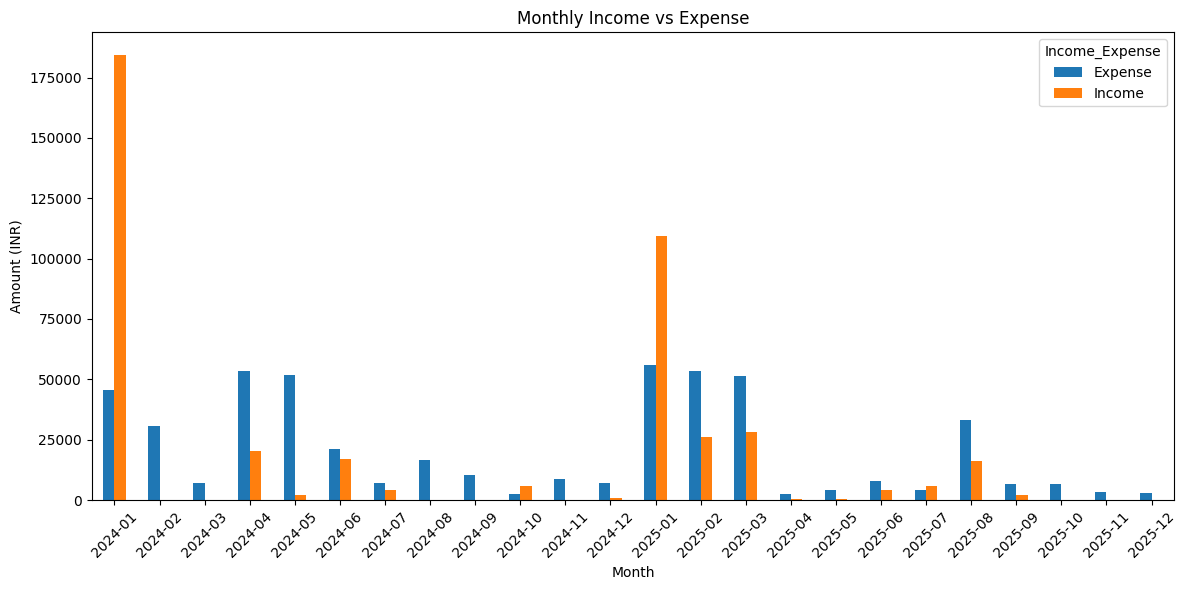

In [ ]:
import matplotlib.pyplot as plt

# Group by Month and Income/Expense
monthly_summary = df.groupby(['Month', 'Income_Expense'])['Amount'].sum().unstack(fill_value=0)

monthly_summary.plot(kind='bar', figsize=(12,6))
plt.title("Monthly Income vs Expense")
plt.ylabel("Amount (INR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate savings
# Group by Month and Income/Expense, sum the amounts, and unstack to get income and expense columns
monthly_income_expense = df.groupby(['Month', 'Income_Expense'])['Amount'].sum().unstack(fill_value=0)

# Calculate savings by subtracting expenses from income
monthly_income_expense['Savings'] = monthly_income_expense.get('Income', 0) - monthly_income_expense.get('Expense', 0)


# Merge savings back to the original monthly_summary dataframe, making sure to align by 'Month' index
monthly_summary = monthly_summary.drop(columns=['Savings'], errors='ignore')
monthly_summary = monthly_summary.merge(monthly_income_expense[['Savings']], left_on='Month', right_index=True, how='left')


# Fill NaN savings with 0 (for months with only income or expense - though the unstack with fill_value=0 should handle this)
monthly_summary['Savings'] = monthly_summary['Savings'].fillna(0)


monthly_summary = monthly_summary.reset_index(drop=True) # drop=True to avoid inserting the old index
monthly_summary['Month_Num'] = np.arange(len(monthly_summary))

print(monthly_summary[['Month', 'Savings']])


# Train model
X = monthly_summary[['Month_Num']]
y = monthly_summary['Savings']
model = LinearRegression().fit(X, y)

# Predict next 3 months
future_months = pd.DataFrame({'Month_Num': [len(monthly_summary)+i for i in range(1, 4)]})
predictions = model.predict(future_months)
print("Predicted savings for next 3 months (Linear Regression):", predictions)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)
future_predictions = poly_model.predict(future_months)
print("Predicted savings for next 3 months (Polynomial Regression):", future_predictions)

predictions = model.predict(future_months)
predictions = [max(0, p) for p in predictions]

print("Adjusted Linear Regression predictions (non-negative): ",predictions)

Income_Expense    Month   Savings
0               2024-01  138829.0
1               2024-02  -30412.0
2               2024-03   -6899.0
3               2024-04  -33084.0
4               2024-05  -49851.0
5               2024-06   -3964.0
6               2024-07   -3083.0
7               2024-08  -16591.0
8               2024-09  -10391.0
9               2024-10    3355.0
10              2024-11   -8621.0
11              2024-12   -5957.0
12              2025-01   53394.0
13              2025-02  -27292.0
14              2025-03  -22834.0
15              2025-04   -2276.0
16              2025-05   -3726.0
17              2025-06   -3725.0
18              2025-07    1635.0
19              2025-08  -17011.0
20              2025-09   -4480.0
21              2025-10   -6563.0
22              2025-11   -3232.0
23              2025-12   -2772.0
Predicted savings for next 3 months (Linear Regression): [-12064.38753623 -12755.72797101 -13447.0684058 ]
Predicted savings for next 3 months (Polyno

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Encode category labels
df = df.dropna(subset=['Category'])
df['Category_Code'] = df['Category'].astype('category').cat.codes

# Prepare features and target
features = df[['Amount', 'Day']]
target = df['Category_Code']

# Train classifier
clf = RandomForestClassifier().fit(features, target)

# Predict category for a new expense
new_expense = pd.DataFrame({'Amount': [6000], 'Day': [15]})
predicted_code = clf.predict(new_expense)

# Decode category
category_map = dict(enumerate(df['Category'].astype('category').cat.categories))
print("Predicted category:", category_map[predicted_code[0]])
print(category_map)
print(predicted_code)

Predicted category: sent-to-friend
{0: 'Anomaly', 1: 'Donation', 2: 'Entertainment', 3: 'From friends', 4: 'Insurence Amount', 5: 'Investment', 6: 'Mobile Bill', 7: 'Modified Bal.', 8: 'Other', 9: 'cashed', 10: 'hostel fee', 11: 'reimbursement', 12: 'savings', 13: 'sent-to-friend', 14: '🍜 Food', 15: '🎁 Gift', 16: '🏅 Bonus', 17: '👬🏻 Social Life', 18: '💄 Beauty', 19: '💰 Salary', 20: '🚖 Transport', 21: '🧘🏼 Health', 22: '🧥 Apparel', 23: '🪑 Household'}
[13]


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Use the monthly_income_expense DataFrame which contains the calculated savings
# The monthly_income_expense DataFrame was created in cell 6Mlb3dbv0Lw-

# Ensure monthly_income_expense is available, if not, recreate it (though it should be from previous execution)
# If running this cell independently, you might need to run the data cleaning and aggregation steps first.
if 'monthly_income_expense' not in locals():
    print("monthly_income_expense not found. Please run the preceding cells.")
else:
    # Prepare data for the model
    # We need a numerical representation of months and the savings
    monthly_income_expense['Month_Num'] = np.arange(len(monthly_income_expense))

    # Train model
    X = monthly_income_expense[['Month_Num']]
    y = monthly_income_expense['Savings']
    model = LinearRegression().fit(X, y)

    # Predict next 6 months
    future_months = pd.DataFrame({'Month_Num': [len(monthly_income_expense) + i for i in range(1, 7)]})
    predictions = model.predict(future_months)

    print("Predicted savings for next 6 months (Linear Regression):", predictions)

    # Optional: Apply non-negative constraint if savings cannot be negative
    # predictions = [max(0, p) for p in predictions]
    # print("Adjusted Linear Regression predictions (non-negative): ", predictions)

Predicted savings for next 6 months (Linear Regression): [-12064.38753623 -12755.72797101 -13447.0684058  -14138.40884058
 -14829.74927536 -15521.08971014]
